# Predicting March Madness

### Import Necessary Libraries

In [302]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.metrics import brier_score_loss

import xgboost as xgb
from xgboost import XGBClassifier

In [249]:
!pip install BracketMaker

### Read in Data

In [716]:
all_games_df = pd.read_csv('Data/all_games_df.csv')

In [251]:
all_games_df.head()

,Season,date,is_tourney,home,HTeamID,hscore,road,RTeamID,rscore,line,...,RFG3,RFG3opponent,RFT,Rwins,Rwins_top25,Rwins_top5,Htourny20plus,Rtourny20plus,HBig4Conf,RBig4Conf
0,2004,11/24/2003,0.0,arizona st.,1113.0,83.0,cal st. fullerton,1168.0,76.0,19.0,...,0.362272,0.387864,0.689468,10,0,0,0,0,0,0
1,2004,12/01/2003,0.0,pepperdine,1337.0,74.0,cal st. fullerton,1168.0,78.0,17.0,...,0.362272,0.387864,0.689468,10,0,0,0,0,0,0
2,2004,01/17/2004,0.0,uc irvine,1414.0,74.0,cal st. fullerton,1168.0,67.0,7.0,...,0.362272,0.387864,0.689468,10,0,0,0,0,0,0
3,2004,01/29/2004,0.0,cal poly slo,1142.0,80.0,cal st. fullerton,1168.0,71.0,5.5,...,0.362272,0.387864,0.689468,10,0,0,0,0,0,0
4,2004,02/21/2004,0.0,utah st.,1429.0,87.0,cal st. fullerton,1168.0,61.0,17.0,...,0.362272,0.387864,0.689468,10,0,0,0,0,0,0


In [252]:
all_games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49062 entries, 0 to 49061
Data columns (total 54 columns):
Season            49062 non-null int64
date              49062 non-null object
is_tourney        49062 non-null float64
home              49062 non-null object
HTeamID           49062 non-null float64
hscore            49062 non-null float64
road              49062 non-null object
RTeamID           49062 non-null float64
rscore            49062 non-null float64
line              49062 non-null float64
lineavg           49062 non-null float64
Hwin              49062 non-null int64
HSeed             49062 non-null float64
RSeed             49062 non-null float64
Hconf             49062 non-null object
Hadjem            49062 non-null float64
Hadjo             49062 non-null float64
Hadjd             49062 non-null float64
Hluck             49062 non-null float64
Rconf             49062 non-null object
Radjem            49062 non-null float64
Radjo             49062 non-null float6

In [661]:
tourney_games_df = all_games_df[all_games_df['is_tourney'] == 1]

In [477]:
tourney_games_df.columns

Index(['Season', 'date', 'is_tourney', 'home', 'HTeamID', 'hscore', 'road',
       'RTeamID', 'rscore', 'line', 'lineavg', 'Hwin', 'HSeed', 'RSeed',
       'Hconf', 'Hadjem', 'Hadjo', 'Hadjd', 'Hluck', 'Rconf', 'Radjem',
       'Radjo', 'Radjd', 'Rluck', 'HRankPOM', 'RRankPOM', 'HScore',
       'HOpponentScore', 'HTOmargin', 'HPointMargin', 'HFG', 'HFGopponent',
       'HFG3', 'HFG3opponent', 'HFT', 'Hwins', 'Hwins_top25', 'Hwins_top5',
       'RScore', 'ROpponentScore', 'RTOmargin', 'RPointMargin', 'RFG',
       'RFGopponent', 'RFG3', 'RFG3opponent', 'RFT', 'Rwins', 'Rwins_top25',
       'Rwins_top5', 'Htourny20plus', 'Rtourny20plus', 'HBig4Conf',
       'RBig4Conf'],
      dtype='object')

In [485]:
non_tourney_games_df = all_games_df[all_games_df['is_tourney'] == 0]

In [717]:
test_combos_df = pd.read_csv('Data/test_combos_df_19.csv')
test_combos_df = test_combos_df.sort_values(by=['ID']).reset_index(drop=True)

### Selected Features to Model

In [254]:
ind_var_selected = [
'is_tourney', 
'HRankPOM',
'RRankPOM',
'line', 
'HTeamID', 
'RTeamID',
'Hwins_top25',
'Rwins_top25',
'HPointMargin',
'RPointMargin',
'HFG',
'RFG',
'HFG3',
'RFG3',
'Hadjem',
'Hadjo',
'Hadjd',
'Hluck',
'Radjem',
'Radjo',
'Radjd',
'Rluck',
'Htourny20plus',
'Rtourny20plus',
'HBig4Conf',
'RBig4Conf', 
'HSeed',
'RSeed'
]

In [255]:
test_ids = test_combos_df['ID'].reset_index(drop=True)
X_test = test_combos_df[['is_tourney','HRankPOM','RRankPOM', 'HTeamID', 'RTeamID', 'Hwins_top25','Rwins_top25', 
                         'HPointMargin','RPointMargin','HFG','RFG','HFG3','RFG3','Hadjem','Hadjo', 
                         'Hadjd','Hluck','Radjem','Radjo','Radjd','Rluck','Htourny20plus', 
                         'Rtourny20plus','HBig4Conf','RBig4Conf','HSeed','RSeed']].reset_index(drop=True)

Here I am going to hold out two years of tournament data to test the model on. I will train the model on all of the data prior to 2017.

In [256]:
#Predict the last two years as a test set (2017, 2018):
temp_df = all_games_df[all_games_df['Season']>2016]
temp_df = temp_df[temp_df['is_tourney']==1]
X_valid = temp_df[ind_var_selected].reset_index(drop=True)
y_valid = temp_df['Hwin'].reset_index(drop=True)

#Train on everything else:
temp_df1 = all_games_df[all_games_df['Season']>2016]
temp_df1 = temp_df1[temp_df1['is_tourney']==0]
temp_df2 = all_games_df[all_games_df['Season']<2017]
combined_temp_df = temp_df1.append(temp_df2)

X_train = combined_temp_df[ind_var_selected].reset_index(drop=True)
y_train = combined_temp_df['Hwin'].reset_index(drop=True)

#For final predictions:
X_train_orig = all_games_df[ind_var_selected].reset_index(drop=True)
y_train_orig = all_games_df['Hwin'].reset_index(drop=True)

In [712]:
X_valid16.shape

(63, 28)

In [711]:
X_train_orig.shape

(49062, 27)

In [257]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 28 columns):
is_tourney       134 non-null float64
HRankPOM         134 non-null int64
RRankPOM         134 non-null int64
line             134 non-null float64
HTeamID          134 non-null float64
RTeamID          134 non-null float64
Hwins_top25      134 non-null int64
Rwins_top25      134 non-null int64
HPointMargin     134 non-null float64
RPointMargin     134 non-null float64
HFG              134 non-null float64
RFG              134 non-null float64
HFG3             134 non-null float64
RFG3             134 non-null float64
Hadjem           134 non-null float64
Hadjo            134 non-null float64
Hadjd            134 non-null float64
Hluck            134 non-null float64
Radjem           134 non-null float64
Radjo            134 non-null float64
Radjd            134 non-null float64
Rluck            134 non-null float64
Htourny20plus    134 non-null int64
Rtourny20plus    134 non-null i

In [258]:
#Create second holdout set to double-check not overfit and check model stability (season 2016)
temp_df16 = all_games_df[all_games_df['Season']==2016]
temp_df16 = temp_df16[temp_df16['is_tourney']==1]
X_valid16 = temp_df16[ind_var_selected].reset_index(drop=True)
y_valid16 = temp_df16['Hwin'].reset_index(drop=True)

temp_df1_16 = all_games_df[all_games_df['Season']==2016]
temp_df1_16 = temp_df1_16[temp_df1_16['is_tourney']==0]
temp_df2_16 = all_games_df[all_games_df['Season']!=2016]
combined_temp_df_16 = temp_df1_16.append(temp_df2_16)

X_train16 = combined_temp_df_16[ind_var_selected].reset_index(drop=True)
y_train16 = combined_temp_df_16['Hwin'].reset_index(drop=True)

### Make all selected features floats

In [259]:
X_test = X_test.astype("float64")

X_train_orig = X_train_orig.astype("float64")
y_train_orig = y_train_orig.astype("float64")

X_train = X_train.astype("float64")
X_valid = X_valid.astype("float64")
y_train = y_train.astype("float64")
y_valid = y_valid.astype("float64")

X_train16 = X_train16.astype("float64")
X_valid16 = X_valid16.astype("float64")
y_train16 = y_train16.astype("float64")
y_valid16 = y_valid16.astype("float64")

### Create a Function to Calculate LogLoss

In [260]:
def LogLoss(predictions, realizations):
    predictions_use = predictions.clip(0)
    realizations_use = realizations.clip(0)
    LogLoss = -np.mean( (realizations_use * np.log(predictions_use)) + 
                        (1 - realizations_use) * np.log(1 - predictions_use) )
    return LogLoss

### Create a Benchmark to try and beat with my Model

In [261]:
bench_5050 = np.repeat(0.5, len(y_valid))

This benchmark finds the LogLoss if the model gives each game a 50/50 probability.

In [262]:
LogLoss(bench_5050, y_valid)

0.6931471805599454

### LogReg Model

This model tries to predict the winners based on the betting markets alone.

In [311]:
X_test

,is_tourney,HRankPOM,RRankPOM,HTeamID,RTeamID,Hwins_top25,Rwins_top25,HPointMargin,RPointMargin,HFG,...,Radjem,Radjo,Radjd,Rluck,Htourny20plus,Rtourny20plus,HBig4Conf,RBig4Conf,HSeed,RSeed
0,1.0,62.0,151.0,1113.0,1101.0,NaN,NaN,NaN,NaN,NaN,...,2.09,103.6,101.5,0.087,0.0,0.0,0.0,0.0,11.0,15.0
1,1.0,14.0,151.0,1120.0,1101.0,NaN,NaN,NaN,NaN,NaN,...,2.09,103.6,101.5,0.087,0.0,0.0,1.0,0.0,5.0,15.0
2,1.0,35.0,151.0,1124.0,1101.0,NaN,NaN,NaN,NaN,NaN,...,2.09,103.6,101.5,0.087,0.0,0.0,1.0,0.0,9.0,15.0
3,1.0,53.0,151.0,1125.0,1101.0,NaN,NaN,NaN,NaN,NaN,...,2.09,103.6,101.5,0.087,0.0,0.0,0.0,0.0,11.0,15.0
4,1.0,151.0,167.0,1101.0,1133.0,NaN,NaN,NaN,NaN,NaN,...,-0.36,100.9,101.2,0.040,0.0,0.0,0.0,0.0,15.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,1.0,20.0,47.0,1459.0,1449.0,NaN,NaN,NaN,NaN,NaN,...,13.37,107.0,93.6,0.078,0.0,0.0,0.0,0.0,7.0,9.0
2274,1.0,47.0,83.0,1449.0,1463.0,NaN,NaN,NaN,NaN,NaN,...,8.59,111.7,103.1,0.057,0.0,0.0,0.0,0.0,9.0,14.0
2275,1.0,12.0,20.0,1458.0,1459.0,NaN,NaN,NaN,NaN,NaN,...,20.71,118.4,97.6,0.060,1.0,0.0,1.0,0.0,5.0,7.0
2276,1.0,12.0,83.0,1458.0,1463.0,NaN,NaN,NaN,NaN,NaN,...,8.59,111.7,103.1,0.057,1.0,0.0,1.0,0.0,5.0,14.0


In [309]:
X_train

,is_tourney,HRankPOM,RRankPOM,line,HTeamID,RTeamID,Hwins_top25,Rwins_top25,HPointMargin,RPointMargin,...,Radjem,Radjo,Radjd,Rluck,Htourny20plus,Rtourny20plus,HBig4Conf,RBig4Conf,HSeed,RSeed
0,0.0,54.0,200.0,12.5,1104.0,1157.0,0.0,0.0,4.151515,-2.870968,...,-3.56,101.8,105.4,0.050,0.0,0.0,1.0,0.0,7.253083,8.279952
1,0.0,83.0,200.0,11.5,1120.0,1157.0,0.0,0.0,0.843750,-2.870968,...,-3.56,101.8,105.4,0.050,0.0,0.0,1.0,0.0,7.253083,8.279952
2,0.0,74.0,200.0,18.0,1140.0,1157.0,1.0,0.0,7.030303,-2.870968,...,-3.56,101.8,105.4,0.050,0.0,0.0,0.0,0.0,7.253083,8.279952
3,0.0,171.0,200.0,3.5,1402.0,1157.0,0.0,0.0,1.806452,-2.870968,...,-3.56,101.8,105.4,0.050,0.0,0.0,0.0,0.0,7.253083,8.279952
4,0.0,130.0,200.0,6.5,1407.0,1157.0,0.0,0.0,3.617647,-2.870968,...,-3.56,101.8,105.4,0.050,0.0,0.0,0.0,0.0,15.000000,8.279952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48923,0.0,220.0,294.0,1.5,1205.0,1144.0,0.0,0.0,-2.966667,-4.407407,...,-12.82,100.2,113.0,-0.030,0.0,0.0,0.0,0.0,7.253083,8.279952
48924,0.0,189.0,321.0,14.0,1316.0,1367.0,0.0,0.0,3.566667,-9.392857,...,-16.03,100.6,116.6,0.007,0.0,0.0,0.0,0.0,7.253083,8.279952
48925,0.0,149.0,334.0,18.0,1436.0,1263.0,0.0,0.0,3.212121,-10.900000,...,-18.23,96.3,114.5,0.030,0.0,0.0,0.0,0.0,7.253083,8.279952
48926,0.0,149.0,232.0,8.5,1436.0,1306.0,0.0,0.0,3.212121,-1.103448,...,-6.01,99.9,105.9,0.110,0.0,0.0,0.0,0.0,7.253083,8.279952


In [306]:
Z1 = LogisticRegression(C = 1e9, random_state=23)
Z1.fit(X_train[['line']], y_train)
Z1_pred = pd.DataFrame(Z1.predict_proba(X_valid[['line']]))[1]

In [307]:
LogLoss(Z1_pred, y_valid)

0.5501231760605553

The betting markets clearly did much better than the 50/50 benchmark.

This model uses only each teams adjusted offensive and defensive efficiences from Kenpom.

In [318]:
Z2 = LogisticRegression(C = 1e9, random_state=23)
Z2.fit(X_train[['Hadjo','Hadjd','Radjo','Radjd']], y_train)
Z2_pred = pd.DataFrame(Z2.predict_proba(X_valid[['Hadjo','Hadjd','Radjo','Radjd']]))[1]

In [319]:
LogLoss(Z2_pred, y_valid)

0.5347689637545485

The Kenpom efficiency model does even better than the betting markets.

In [267]:
Z1 = LogisticRegression(C = 1e9, random_state=23)
Z1.fit(X_train16[['line']], y_train16)
Z1_pred = pd.DataFrame(Z1.predict_proba(X_valid16[['line']]))[1]

In [268]:
LogLoss(Z1_pred, y_valid16)

0.5380737902211371

In [269]:
Z2 = LogisticRegression(C = 1e9, random_state=23)
Z2.fit(X_train16[['Hadjo','Hadjd','Radjo','Radjd']], y_train16)
Z2_pred = pd.DataFrame(Z2.predict_proba(X_valid16[['Hadjo','Hadjd','Radjo','Radjd']]))[1]

In [270]:
Z2_pred_probs = Z2.predict_proba(X_valid16[['Hadjo','Hadjd','Radjo','Radjd']])

In [271]:
LogLoss(Z2_pred, y_valid16)

0.5214560672166632

In [320]:
Z3_pred = pd.DataFrame(Z2.predict_proba(X_test[['Hadjo','Hadjd','Radjo','Radjd']]))[1]

In [322]:
Z3_pred_probs = Z2.predict_proba(X_test[['Hadjo','Hadjd','Radjo','Radjd']])

In [325]:
Z3_pred_probs

array([[0.15558863, 0.84441137],
       [0.03891024, 0.96108976],
       [0.09956125, 0.90043875],
       ...,
       [0.28075826, 0.71924174],
       [0.08100124, 0.91899876],
       [0.10878783, 0.89121217]])

In [714]:
len(Z3_pred_probs)

2278

Add Predictions to Dataframe

In [326]:
probs_list = list(range(len(Z3_pred_probs)))

In [327]:
probs = []
for prob in Z3_pred_probs:
        home = prob[1]
        away = prob[0]
        prob_dict = {'home_w_prob' : home, 'away_w_prob' : away}
        probs.append(prob_dict)

In [328]:
df = pd.DataFrame(probs)

In [329]:
preds19 = pd.concat([X_test, df], axis=1, sort=False)

In [330]:
preds19 = preds19[['HTeamID', 'RTeamID', 'home_w_prob']]

In [333]:
preds19.head()

,HTeamID,RTeamID,home_w_prob
0,1113.0,1101.0,0.844411
1,1120.0,1101.0,0.961090
2,1124.0,1101.0,0.900439
3,1125.0,1101.0,0.872959
4,1101.0,1133.0,0.701601


In [718]:
teams_df = pd.read_csv('Data/mens-machine-learning-competition-2019/DataFiles/Teams.csv')

In [335]:
teams_df = teams_df[['TeamID', 'TeamName']]

In [336]:
teams_df = teams_df.rename(columns={"TeamID": "HTeamID"})

In [338]:
preds19 = pd.merge(preds19, teams_df, how='left', on=['HTeamID'])

In [339]:
preds19 = preds19.rename(columns={"TeamName": "HTeamName"})

In [340]:
preds19.head()

,HTeamID,RTeamID,home_w_prob,HTeamName
0,1113.0,1101.0,0.844411,Arizona St
1,1120.0,1101.0,0.961090,Auburn
2,1124.0,1101.0,0.900439,Baylor
3,1125.0,1101.0,0.872959,Belmont
4,1101.0,1133.0,0.701601,Abilene Chr


In [341]:
teams_df = teams_df.rename(columns={"HTeamID": "RTeamID"})

In [342]:
preds19 = pd.merge(preds19, teams_df, how='left', on=['RTeamID'])

In [343]:
preds19 = preds19.rename(columns={"TeamName": "RTeamName"})

In [344]:
preds19 = preds19[['HTeamName', 'RTeamName', 'home_w_prob']]

In [715]:
len(preds19[preds19['home_w_prob'] < 0.5])

11

In [347]:
len(preds19)

2278

In [470]:
preds19.loc[(preds19['HTeamName'] == 'F Dickinson') & (preds19['RTeamName'] == "Prairie View")]

,HTeamName,RTeamName,home_w_prob
660,F Dickinson,Prairie View,0.643959


In [713]:
# sorted(list(preds19['RTeamName'].unique()))

### Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
from sklearn.metrics import log_loss

In [28]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_prob = pd.DataFrame(dt.predict_proba(X_valid))
# LogLoss(dt_prob[1], y_valid)

### Random Forest

In [29]:
clf = RandomForestClassifier(n_estimators=200, max_depth=3, min_samples_leaf=3)
clf.fit(X_train, y_train)
rf_prob = pd.DataFrame(clf.predict_proba(X_valid))
LogLoss(rf_prob[1], y_valid)

0.5658478089569049

# New Model

In [30]:
# pip install pandas sklearn sportsreference

In [31]:
from sportsreference.ncaab.teams import Teams
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [32]:
# FIELDS_TO_DROP = ['away_points', 'home_points', 'date', 'location',
#                   'losing_abbr', 'losing_name', 'winner', 'winning_abbr',
#                   'winning_name', 'home_ranking', 'away_ranking']

# dataset = pd.DataFrame()
# teams = Teams()
# for team in teams:
#     dataset = pd.concat([dataset, team.schedule.dataframe_extended])

In [33]:
# X = dataset.drop(FIELDS_TO_DROP, 1).dropna().drop_duplicates()
# y = dataset[['home_points', 'away_points']].values
# X_train, X_test, y_train, y_test = train_test_split(X, y)
# parameters = {'bootstrap': False,
#               'min_samples_leaf': 3,
#               'n_estimators': 50,
#               'min_samples_split': 10,
#               'max_features': 'sqrt',
#               'max_depth': 6}
# model = RandomForestRegressor(**parameters)
# model.fit(X_train, y_train)
# print(model.predict(X_test).astype(int), y_test)

### TrueSkill

### Visuals

In [663]:
tourney_games_df.columns

Index(['Season', 'date', 'is_tourney', 'home', 'HTeamID', 'hscore', 'road',
       'RTeamID', 'rscore', 'line', 'lineavg', 'Hwin', 'HSeed', 'RSeed',
       'Hconf', 'Hadjem', 'Hadjo', 'Hadjd', 'Hluck', 'Rconf', 'Radjem',
       'Radjo', 'Radjd', 'Rluck', 'HRankPOM', 'RRankPOM', 'HScore',
       'HOpponentScore', 'HTOmargin', 'HPointMargin', 'HFG', 'HFGopponent',
       'HFG3', 'HFG3opponent', 'HFT', 'Hwins', 'Hwins_top25', 'Hwins_top5',
       'RScore', 'ROpponentScore', 'RTOmargin', 'RPointMargin', 'RFG',
       'RFGopponent', 'RFG3', 'RFG3opponent', 'RFT', 'Rwins', 'Rwins_top25',
       'Rwins_top5', 'Htourny20plus', 'Rtourny20plus', 'HBig4Conf',
       'RBig4Conf'],
      dtype='object')

In [664]:
tourney_games_df['HSeed']

55        6.0
70        8.0
254       1.0
255       2.0
257       3.0
         ... 
48749     1.0
48789     1.0
48924     5.0
49012    16.0
49050    16.0
Name: HSeed, Length: 919, dtype: float64

In [665]:
tourney_games_df.groupby('HSeed')['Hadjo'].mean()

HSeed
1.0     119.748387
2.0     117.543506
3.0     115.856154
4.0     115.439286
5.0     113.898529
6.0     113.727273
7.0     113.768750
8.0     113.054098
9.0     110.666667
10.0    110.200000
11.0    113.738462
12.0    111.266667
13.0    113.200000
14.0    106.300000
16.0    101.866667
Name: Hadjo, dtype: float64

In [666]:
tourney_games_df.groupby('RSeed')['Radjo'].mean()

RSeed
1.0     122.544444
2.0     118.466667
3.0     116.517143
4.0     115.735484
5.0     115.113725
6.0     113.491892
7.0     114.328070
8.0     114.018182
9.0     111.237931
10.0    112.650602
11.0    111.873214
12.0    110.667500
13.0    108.327027
14.0    108.143077
15.0    104.554098
16.0    102.128788
Name: Radjo, dtype: float64

In [667]:
tourney_games_df.groupby('HSeed')['line'].mean()

HSeed
1.0     9.976959
2.0     8.837662
3.0     6.573077
4.0     6.156250
5.0     5.147059
6.0     3.219275
7.0     1.601562
8.0     0.737705
9.0     5.333333
10.0    2.600000
11.0    2.269231
12.0    3.777778
13.0    1.500000
14.0    2.000000
16.0    2.400000
Name: line, dtype: float64

In [668]:
tourney_games_df.groupby('RSeed')['line'].mean()

RSeed
1.0      1.444444
2.0      1.425926
3.0      3.714286
4.0      3.467742
5.0      3.598039
6.0      4.067568
7.0      4.596491
8.0      6.897727
9.0      3.091954
10.0     2.704819
11.0     3.714037
12.0     5.575000
13.0     8.216216
14.0     9.876923
15.0    15.721311
16.0    17.560606
Name: line, dtype: float64

In [669]:
trial = tourney_games_df[['HSeed']]

In [670]:
trial = trial.rename(columns={"HSeed": "Seed"})

In [671]:
trial2 = tourney_games_df[['RSeed']]

In [672]:
trial2 = trial2.rename(columns={"RSeed": "Seed"})

In [673]:
trial = trial.append(trial2)

In [674]:
trial2 = tourney_games_df[['Hadjo']]

In [675]:
trial2 = trial2.rename(columns={"Hadjo": "Adjo"})

In [676]:
trial3 = tourney_games_df[['Radjo']]

In [677]:
trial3 = trial3.rename(columns={"Radjo": "Adjo"})

In [678]:
trial2 = trial2.append(trial3)

In [679]:
trial = pd.concat([trial, trial2], axis=1)

In [680]:
trial2 = tourney_games_df[['Hadjd']]

In [681]:
trial2 = trial2.rename(columns={"Hadjd": "Adjd"})

In [682]:
trial3 = tourney_games_df[['Radjd']]

In [683]:
trial3 = trial3.rename(columns={"Radjd": "Adjd"})

In [684]:
trial2 = trial2.append(trial3)

In [685]:
trial = pd.concat([trial, trial2], axis=1)

In [686]:
trial

,Seed,Adjo,Adjd
55,6.0,113.6,95.0
70,8.0,112.3,95.0
254,1.0,120.8,88.5
255,2.0,114.7,92.9
257,3.0,115.6,94.1
...,...,...,...
48749,16.0,102.9,102.9
48789,16.0,104.6,111.2
48924,12.0,112.9,100.7
49012,16.0,102.3,110.6


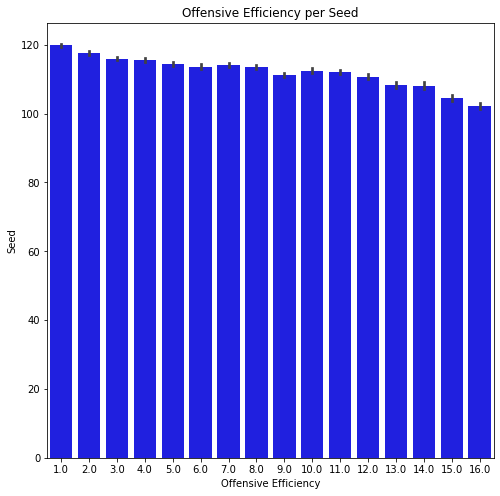

In [687]:
plt.figure(figsize = (8,8))
sns.barplot(trial['Seed'], trial['Adjo'], color = 'blue')
plt.title("Offensive Efficiency per Seed")
plt.xlabel("Offensive Efficiency")
plt.ylabel("Seed")
plt.show()

In [688]:
tourney_games_df.columns

Index(['Season', 'date', 'is_tourney', 'home', 'HTeamID', 'hscore', 'road',
       'RTeamID', 'rscore', 'line', 'lineavg', 'Hwin', 'HSeed', 'RSeed',
       'Hconf', 'Hadjem', 'Hadjo', 'Hadjd', 'Hluck', 'Rconf', 'Radjem',
       'Radjo', 'Radjd', 'Rluck', 'HRankPOM', 'RRankPOM', 'HScore',
       'HOpponentScore', 'HTOmargin', 'HPointMargin', 'HFG', 'HFGopponent',
       'HFG3', 'HFG3opponent', 'HFT', 'Hwins', 'Hwins_top25', 'Hwins_top5',
       'RScore', 'ROpponentScore', 'RTOmargin', 'RPointMargin', 'RFG',
       'RFGopponent', 'RFG3', 'RFG3opponent', 'RFT', 'Rwins', 'Rwins_top25',
       'Rwins_top5', 'Htourny20plus', 'Rtourny20plus', 'HBig4Conf',
       'RBig4Conf'],
      dtype='object')

In [689]:
x = tourney_games_df[['Hwin']]

In [690]:
y = tourney_games_df[['Hwin']]

In [691]:
blank_list = []
for i in y['Hwin']:
    if i == 1:
        i = 0
        blank_dict = {'Win': i}
        blank_list.append(blank_dict)
    else:
        i = 1
        blank_dict = {'Win': i}
        blank_list.append(blank_dict)
    

In [692]:
y = pd.DataFrame(blank_list)

In [693]:
x = x.rename(columns={"Hwin": "Win"})

In [694]:
x = x.reset_index(drop=True)

In [695]:
y = y.reset_index(drop=True)

In [696]:
x = x.append(y)

In [697]:
x = x.reset_index(drop=True)

In [698]:
trial = trial.reset_index(drop=True)

In [699]:
trial = pd.concat([trial, x], axis=1)

In [701]:
trial.head()

,Seed,Adjo,Adjd,Win
0,6.0,113.6,95.0,1
1,8.0,112.3,95.0,1
2,1.0,120.8,88.5,1
3,2.0,114.7,92.9,0
4,3.0,115.6,94.1,0


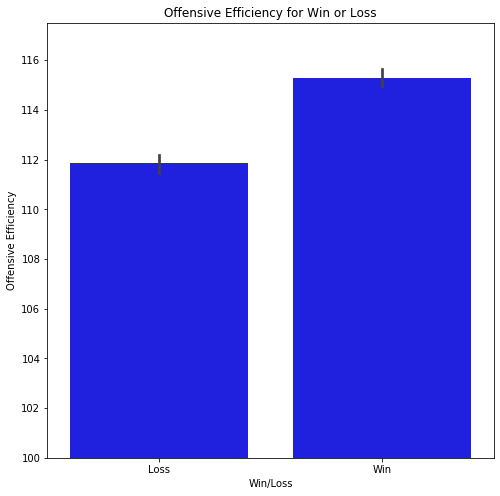

In [726]:
plt.figure(figsize = (8,8))
sns.barplot(trial['Win'], trial['Adjo'], color = 'blue')
plt.title("Offensive Efficiency for Win or Loss")
plt.xlabel("Win/Loss")
plt.ylabel("Offensive Efficiency")
plt.ylim(100, 117.5)
plt.xticks([0, 1], ['Loss', 'Win'])
plt.show()

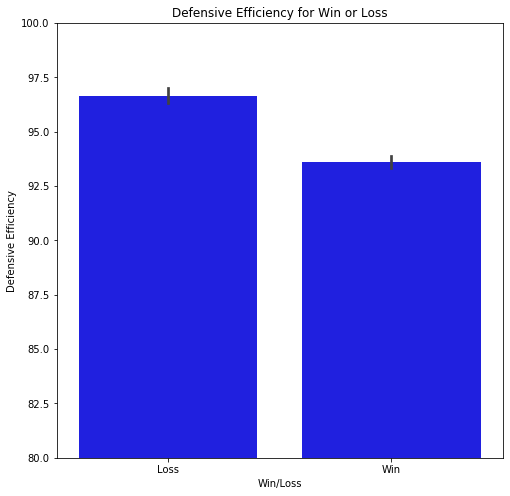

In [725]:
plt.figure(figsize = (8,8))
sns.barplot(trial['Win'], trial['Adjd'], color = 'blue')
plt.title("Defensive Efficiency for Win or Loss")
plt.xlabel("Win/Loss")
plt.ylabel("Defensive Efficiency")
plt.ylim(80, 100)
plt.xticks([0, 1], ['Loss', 'Win'])
plt.show()